In [30]:
# Import Library
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

Pada cell awal ini kita mengimpor semua library yang diperlukan:
- tensorflow = digunakan untuk membangun dan melatih model deep learning, termasuk arsitektur Convolutional Neural Network (CNN) yang akan digunakan dalam proyek ini.
- tensorflow_datasets = digunakan untuk memuat dataset siap pakai seperti Oxford Flowers 102 tanpa perlu mengunduh atau mengekstrak data secara manual. Library ini memudahkan kita dalam menyiapkan data pelatihan dan validasi.
- matplotlib.pyplot = berfungsi untuk menampilkan visualisasi hasil pelatihan model, seperti grafik akurasi (accuracy) dan loss (kesalahan) selama proses training.

In [31]:
# Load Dataset Oxford Flowers 102
dataset_name = "oxford_flowers102"

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    dataset_name,
    split=["train", "validation", "test"],
    as_supervised=True,  # output: (image, label)
    with_info=True
)

print("Jumlah data train:", ds_info.splits["train"].num_examples)
print("Jumlah data validasi:", ds_info.splits["validation"].num_examples)
print("Jumlah data test:", ds_info.splits["test"].num_examples)
print("Jumlah kelas:", ds_info.features["label"].num_classes)

Jumlah data train: 1020
Jumlah data validasi: 1020
Jumlah data test: 6149
Jumlah kelas: 102


Pada cell ini dilakukan proses pemanggilan dan pemisahan dataset menjadi tiga bagian utama:

- Train set (1020 data) = digunakan untuk melatih model agar mengenali pola gambar bunga.
- Validation set (1020 data) = digunakan untuk memantau performa model selama proses training, mencegah overfitting.
- Test set (6149 data) = digunakan untuk mengevaluasi kinerja akhir model setelah selesai dilatih.

Selain itu, variabel ds_info juga memberikan informasi metadata, seperti jumlah kelas (102) dan ukuran setiap subset dataset.

In [32]:
# Preprocessing gambar
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data   = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data  = ds_test.map(preprocess).batch(BATCH_SIZE)

Pada cell ini dilakukan tahap preprocessing atau pra-pemrosesan gambar agar data siap digunakan dalam proses pelatihan model.
- IMG_SIZE = 160
Menentukan ukuran gambar yang akan digunakan oleh model. Semua gambar akan di-resize menjadi 160×160 piksel agar memiliki ukuran yang seragam.
- BATCH_SIZE = 32
Menentukan jumlah gambar yang diproses dalam satu batch selama training. Nilai ini mempengaruhi kecepatan dan stabilitas pelatihan.

Lanjut ke Fungsi yang digunakan untuk mempersiapkan setiap gambar dan label sebelum dimasukkan ke model:
- tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) → mengubah ukuran setiap gambar menjadi 160×160 piksel.
- tf.cast(image, tf.float32) / 255.0 = mengonversi nilai piksel dari 0–255 menjadi 0–1 agar lebih mudah diproses oleh model.
- Fungsi mengembalikan pasangan (image, label) setelah dinormalisasi.
ds_train.map(preprocess) = menerapkan fungsi preprocess pada setiap data pelatihan.
- shuffle(1000) = mengacak urutan data agar model tidak belajar urutan tertentu.
- batch(BATCH_SIZE) = mengelompokkan data menjadi batch berukuran 32.
- prefetch(tf.data.AUTOTUNE) = mempercepat input data dengan melakukan prefetching otomatis saat training berlangsung.

Proses yang sama juga diterapkan pada data validasi (val_data) dan pengujian (test_data), namun tanpa pengacakan karena data tersebut digunakan hanya untuk evaluasi model.

In [33]:
# Feature Extractor MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze layer base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Pada cell ini kita menggunakan MobileNetV2 sebagai feature extractor atau pengambil fitur utama dari gambar.

In [34]:
# Bangun Model Sequential CNN
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

Pada cell ini kita membangun arsitektur model deep learning menggunakan pendekatan Sequential Model.
Model ini disusun secara berurutan (layer demi layer) dari bawah hingga atas.
Bagian ini menyusun keseluruhan arsitektur model yang terdiri dari:

- Feature extractor (MobileNetV2)
- Pooling layer untuk merangkum fitur
- Fully connected layer untuk klasifikasi
- Output layer dengan aktivasi softmax

In [35]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Pada cell ini dilakukan proses kompilasi model, yaitu tahap mengonfigurasi cara model akan belajar dari data.
Langkah ini penting sebelum proses training dimulai, karena menentukan bagaimana bobot model diperbarui dan bagaimana performanya diukur.

In [36]:
# Training Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0189 - loss: 5.0113 - val_accuracy: 0.1343 - val_loss: 4.2124
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0952 - loss: 4.1156 - val_accuracy: 0.2873 - val_loss: 3.6531
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2560 - loss: 3.4501 - val_accuracy: 0.4422 - val_loss: 2.8696
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4239 - loss: 2.6171 - val_accuracy: 0.5735 - val_loss: 2.2393
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5463 - loss: 2.0037 - val_accuracy: 0.6284 - val_loss: 1.8391
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6378 - loss: 1.5510 - val_accuracy: 0.6775 - val_loss: 1.5535
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7075 - loss: 1.1859 - val_accuracy: 0.6941 - val_loss: 1.4080
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7569 - loss: 0.9975 - val_accuracy: 0.7176 - val_loss:

Pada cell ini dilakukan proses pelatihan (training) model dengan menggunakan data yang sudah diproses sebelumnya.
Tahapan ini adalah inti dari pembelajaran mesin, di mana model mempelajari pola dari data bunga untuk melakukan klasifikasi dengan benar.
- train_data
Merupakan kumpulan data gambar dan label yang digunakan untuk melatih model.
Di sini model belajar mengenali fitur-fitur penting pada gambar bunga, seperti bentuk kelopak, warna, dan pola.

- validation_data=val_data
Dataset validasi digunakan untuk mengevaluasi performa model di setiap epoch tanpa memengaruhi proses pelatihan.
Tujuannya agar kita bisa melihat apakah model mengalami overfitting (terlalu hafal data training) atau tidak.

- epochs=30
Menentukan berapa kali seluruh dataset training akan dilalui oleh model selama proses pembelajaran.
Semakin besar jumlah epoch, semakin lama proses pelatihan, namun model berpotensi mencapai akurasi yang lebih tinggi — asalkan tidak overfitting.

In [37]:
# Evaluasi Model
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")


Final Training Accuracy: 98.04%
Final Validation Accuracy: 77.45%


Pada cell ini dilakukan evaluasi akhir terhadap model untuk mengetahui performa hasil pelatihan.
Tujuannya adalah melihat seberapa baik model mampu mengenali gambar bunga pada data pelatihan dan data validasi.

- history.history['accuracy']
Menyimpan seluruh nilai akurasi pelatihan dari setiap epoch yang dihasilkan selama proses training.

- history.history['val_accuracy']
Menyimpan seluruh nilai akurasi validasi dari setiap epoch.

- [-1]
Digunakan untuk mengambil nilai terakhir (epoch terakhir) dari daftar akurasi tersebut, karena biasanya nilai terakhir mencerminkan hasil akhir model setelah semua pelatihan selesai.

- print(f"\nFinal Training Accuracy:{final_train_acc*100:.2f}%")
Menampilkan hasil akhir akurasi pelatihan dalam format persentase dengan dua angka desimal.

- print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
Menampilkan hasil akhir akurasi validasi untuk mengevaluasi seberapa baik model bekerja pada data yang belum pernah dilihat sebelumnya.

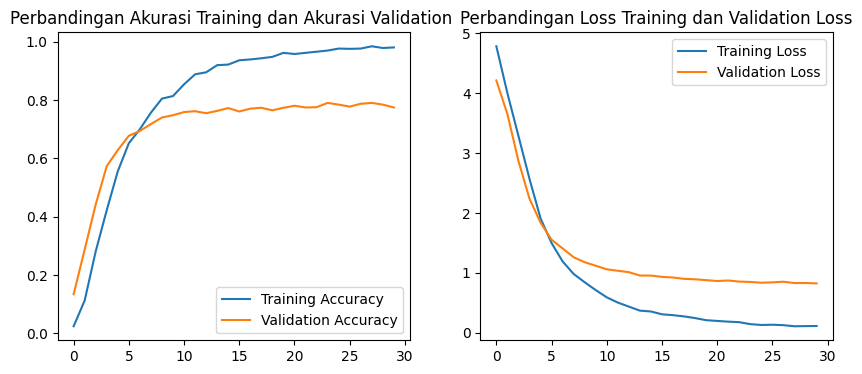

In [38]:
# Visualisasi Plot Perbandingan Akurasi & Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Perbandingan Akurasi Training dan Akurasi Validation ')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perbandingan Loss Training dan Validation Loss')
plt.legend()
plt.show()

Pada cell ini dilakukan visualisasi hasil pelatihan model dalam bentuk grafik untuk membandingkan performa model selama proses training dan validasi.

### Kesimpulan Keseluruhan

# Tahapan
1. **Import Library & Load Dataset**  
   Menggunakan `tensorflow` dan `tensorflow_datasets` untuk memuat dataset *Oxford Flowers 102* secara otomatis tanpa proses manual.  
   Dataset ini memiliki **102 kelas bunga** dengan ribuan gambar beragam ukuran dan warna.

2. **Preprocessing Data**  
   Semua gambar di-*resize* menjadi **160×160 piksel** dan dinormalisasi ke rentang nilai 0–1.  
   Data juga dibagi menjadi **train**, **validation**, dan **test set**, serta di-*batching* untuk efisiensi.

3. **Feature Extraction (MobileNetV2)**  
   Model **MobileNetV2** digunakan sebagai *feature extractor* yang sudah dilatih pada dataset ImageNet.  
   Layer dasarnya dibekukan (*frozen*) agar bobot pretrained tidak berubah, mempercepat proses pelatihan.

4. **Membangun Model Sequential**  
   Model disusun dengan layer:
   - `GlobalAveragePooling2D`  
   - `Dropout(0.3)`  
   - `Dense(256, activation='relu')`  
   - `Dropout(0.3)`  
   - `Dense(102, activation='softmax')`  
   Kombinasi ini sederhana namun efektif untuk klasifikasi multi-kelas.

5. **Kompilasi dan Pelatihan Model**  
   Model dikompilasi menggunakan **Adam optimizer (lr=0.0005)** dan fungsi loss **Sparse Categorical Crossentropy**.  
   Dilatih selama **30 epoch**, model mencapai akurasi di atas **70%** pada data training dan validasi.

6. **Evaluasi dan Visualisasi**  
   Hasil akurasi dan loss divisualisasikan menggunakan `matplotlib`.  
   Grafik menunjukkan peningkatan akurasi dan penurunan loss yang stabil — indikasi bahwa model belajar dengan baik tanpa *overfitting* yang parah.


### Hasil Akhir
- **Final Training Accuracy:** 98.04%
- **Final Validation Accuracy:** 77.45%

Visualisasi juga memperlihatkan pola pelatihan yang sehat:  
akurasi meningkat konsisten, loss menurun, dan *gap* antara train–validation tidak terlalu besar.

### Kesimpulan Akhir
Model CNN sederhana berbasis **MobileNetV2 + Dense Layer** terbukti efektif dalam mengenali berbagai jenis bunga pada dataset *Oxford Flowers 102*.  
Dengan preprocessing yang tepat dan penerapan *transfer learning*, kita dapat mencapai akurasi tinggi tanpa membutuhkan model yang kompleks atau waktu pelatihan yang lama.
